In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import TimeDistributed, BatchNormalization, Bidirectional, Input, MaxPooling3D, MaxPooling2D, Dropout, UpSampling3D, UpSampling2D, UpSampling1D
from keras.models import Model
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import os
from keras.layers import ConvLSTM2D, ConvLSTM1D
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
path= '/content/drive/MyDrive/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv'

In [ ]:
df = pd.read_csv('Friday-02-03-2018_TrafficForML_CICFlowMeter.csv')
df

Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0             443         6  02/03/2018 08:47:38         141385             9   
1           49684         6  02/03/2018 08:47:38            281             2   
2             443         6  02/03/2018 08:47:40         279824            11   
3             443         6  02/03/2018 08:47:40            132             2   
4             443         6  02/03/2018 08:47:41         274016             9   
...           ...       ...                  ...            ...           ...   
1048570      3389         6  02/03/2018 02:08:18        3982183            14   
1048571      3389         6  02/03/2018 02:08:22        3802316            14   
1048572      3389         6  02/03/2018 02:08:25        4004239            14   
1048573      3389         6  02/03/2018 02:08:29        3998435            14   
1048574      3389         6  02/03/2018 02:08:33        3972651            14   

         Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0                   7              553           3773.0              202   
1                   1               38              0.0               38   
2                  15             1086          10527.0              385   
3                   0                0              0.0                0   
4                  13             1285           6141.0              517   
...               ...              ...              ...              ...   
1048570             8             1442           1731.0              725   
1048571             8             1440           1731.0              725   
1048572             8             1459           1731.0              741   
1048573             8             1459           1731.0              741   
1048574             8             1439           1731.0              725   

         Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean  Active Std  \
0                      0  ...                20          0.0         0.0   
1                      0  ...                20          0.0         0.0   
2                      0  ...                20          0.0         0.0   
3                      0  ...                20          0.0         0.0   
4                      0  ...                20          0.0         0.0   
...                  ...  ...               ...          ...         ...   
1048570                0  ...                20          0.0         0.0   
1048571                0  ...                20          0.0         0.0   
1048572                0  ...                20          0.0         0.0   
1048573                0  ...                20          0.0         0.0   
1048574                0  ...                20          0.0         0.0   

         Active Max  Active Min  Idle Mean  Idle Std  Idle Max  Idle Min  \
0               0.0         0.0        0.0       0.0       0.0       0.0   
1               0.0         0.0        0.0       0.0       0.0       0.0   
2               0.0         0.0        0.0       0.0       0.0       0.0   
3               0.0         0.0        0.0       0.0       0.0       0.0   
4               0.0         0.0        0.0       0.0       0.0       0.0   
...             ...         ...        ...       ...       ...       ...   
1048570         0.0         0.0        0.0       0.0       0.0       0.0   
1048571         0.0         0.0        0.0       0.0       0.0       0.0   
1048572         0.0         0.0        0.0       0.0       0.0       0.0   
1048573         0.0         0.0        0.0       0.0       0.0       0.0   
1048574         0.0         0.0        0.0       0.0       0.0       0.0   

          Label  
0        Benign  
1        Benign  
2        Benign  
3        Benign  
4        Benign  
...         ...  
1048570  Benign  
1048571  Benign  
1048572  Benign  
1048573  Benign  
1048574  Benign  

[1048575 rows x 80 columns]

In [ ]:
df = pd.read_csv(path)
df

In [ ]:
# Remove erroneous 'Label' row
df.drop(df.loc[df["Label"] == "Label"].index, inplace=True)

# Forcing 'Protocol' column to be strings and one-hot encoding
df = df.astype({"Protocol": str})
df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)

In [ ]:
df["Label"].unique()

array(['Benign', 'Bot'], dtype=object)

In [ ]:
df['Label'] = df['Label'].replace({'Benign': 0, 'Bot':1})

In [ ]:
df.head()

Dst Port            Timestamp  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0       443  02/03/2018 08:47:38         141385             9             7   
1     49684  02/03/2018 08:47:38            281             2             1   
2       443  02/03/2018 08:47:40         279824            11            15   
3       443  02/03/2018 08:47:40            132             2             0   
4       443  02/03/2018 08:47:41         274016             9            13   

   TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  \
0              553           3773.0              202                0   
1               38              0.0               38                0   
2             1086          10527.0              385                0   
3                0              0.0                0                0   
4             1285           6141.0              517                0   

   Fwd Pkt Len Mean  ...  Active Std  Active Max  Active Min  Idle Mean  \
0         61.444444  ...         0.0         0.0         0.0        0.0   
1         19.000000  ...         0.0         0.0         0.0        0.0   
2         98.727273  ...         0.0         0.0         0.0        0.0   
3          0.000000  ...         0.0         0.0         0.0        0.0   
4        142.777778  ...         0.0         0.0         0.0        0.0   

   Idle Std  Idle Max  Idle Min  Label  Protocol_17  Protocol_6  
0       0.0       0.0       0.0      0        False        True  
1       0.0       0.0       0.0      0        False        True  
2       0.0       0.0       0.0      0        False        True  
3       0.0       0.0       0.0      0        False        True  
4       0.0       0.0       0.0      0        False        True  

[5 rows x 81 columns]

In [ ]:
# Remove erroneous 'Label' row
df.drop(df.loc[df["Label"] == "Label"].index, inplace=True)

In [ ]:
# Drop unnecessary columns
columns_to_drop = [
    'Dst Port',
    'Timestamp',
    'Fwd PSH Flags',
    'Bwd PSH Flags',
    'Fwd URG Flags',
    'Bwd URG Flags',
    'Flow Byts/s',  # This field had np.inf values during training, as such was removed
    'Flow Pkts/s'  # This field had np.inf values during training, as such was removed
]
df.drop(columns=columns_to_drop, inplace=True)
df

Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0               141385             9             7              553   
1                  281             2             1               38   
2               279824            11            15             1086   
3                  132             2             0                0   
4               274016             9            13             1285   
...                ...           ...           ...              ...   
1048570        3982183            14             8             1442   
1048571        3802316            14             8             1440   
1048572        4004239            14             8             1459   
1048573        3998435            14             8             1459   
1048574        3972651            14             8             1439   

         TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  Fwd Pkt Len Mean  \
0                 3773.0              202                0         61.444444   
1                    0.0               38                0         19.000000   
2                10527.0              385                0         98.727273   
3                    0.0                0                0          0.000000   
4                 6141.0              517                0        142.777778   
...                  ...              ...              ...               ...   
1048570           1731.0              725                0        103.000000   
1048571           1731.0              725                0        102.857143   
1048572           1731.0              741                0        104.214286   
1048573           1731.0              741                0        104.214286   
1048574           1731.0              725                0        102.785714   

         Fwd Pkt Len Std  Bwd Pkt Len Max  ...  Active Std  Active Max  \
0              87.534438             1460  ...         0.0         0.0   
1              26.870058                0  ...         0.0         0.0   
2             129.392497             1460  ...         0.0         0.0   
3               0.000000                0  ...         0.0         0.0   
4             183.887722             1460  ...         0.0         0.0   
...                  ...              ...  ...         ...         ...   
1048570       191.125412             1179  ...         0.0         0.0   
1048571       191.172841             1179  ...         0.0         0.0   
1048572       195.113450             1179  ...         0.0         0.0   
1048573       195.113450             1179  ...         0.0         0.0   
1048574       191.197111             1179  ...         0.0         0.0   

         Active Min  Idle Mean  Idle Std  Idle Max  Idle Min  Label  \
0               0.0        0.0       0.0       0.0       0.0      0   
1               0.0        0.0       0.0       0.0       0.0      0   
2               0.0        0.0       0.0       0.0       0.0      0   
3               0.0        0.0       0.0       0.0       0.0      0   
4               0.0        0.0       0.0       0.0       0.0      0   
...             ...        ...       ...       ...       ...    ...   
1048570         0.0        0.0       0.0       0.0       0.0      0   
1048571         0.0        0.0       0.0       0.0       0.0      0   
1048572         0.0        0.0       0.0       0.0       0.0      0   
1048573         0.0        0.0       0.0       0.0       0.0      0   
1048574         0.0        0.0       0.0       0.0       0.0      0   

         Protocol_17  Protocol_6  
0              False        True  
1              False        True  
2              False        True  
3              False        True  
4              False        True  
...              ...         ...  
1048570        False        True  
1048571        False        True  
1048572        False        True  
1048573        False        True  
1048574        False        True  

[1048575 rows x 73 columns]

In [ ]:
# Remove missing values and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
# Replace infinities with NaN and then drop NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [ ]:
df.head()

Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0         141385             9             7              553   
1            281             2             1               38   
2         279824            11            15             1086   
3            132             2             0                0   
4         274016             9            13             1285   

   TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  Fwd Pkt Len Mean  \
0           3773.0              202                0         61.444444   
1              0.0               38                0         19.000000   
2          10527.0              385                0         98.727273   
3              0.0                0                0          0.000000   
4           6141.0              517                0        142.777778   

   Fwd Pkt Len Std  Bwd Pkt Len Max  ...  Active Std  Active Max  Active Min  \
0        87.534438             1460  ...         0.0         0.0         0.0   
1        26.870058                0  ...         0.0         0.0         0.0   
2       129.392497             1460  ...         0.0         0.0         0.0   
3         0.000000                0  ...         0.0         0.0         0.0   
4       183.887722             1460  ...         0.0         0.0         0.0   

   Idle Mean  Idle Std  Idle Max  Idle Min  Label  Protocol_17  Protocol_6  
0        0.0       0.0       0.0       0.0      0        False        True  
1        0.0       0.0       0.0       0.0      0        False        True  
2        0.0       0.0       0.0       0.0      0        False        True  
3        0.0       0.0       0.0       0.0      0        False        True  
4        0.0       0.0       0.0       0.0      0        False        True  

[5 rows x 73 columns]

In [ ]:
# Separate features and labels
X = df.drop(["Label"], axis=1)
y = df["Label"]

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Standardize the features
ss = StandardScaler()
X = ss.fit_transform(X)

# Encode the labels
le = LabelEncoder()

# If y is a numpy array, use np.unique to get unique target classes
target_class = np.unique(y)

# Transform the labels using LabelEncoder
y = le.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y) # random state 4

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_train = np.expand_dims(X_train,axis=1)
X_test = np.expand_dims(X_test,axis=1)

print(X_train.shape)
print(X_test.shape)

(579122, 1, 72, 1)
(193041, 1, 72, 1)


In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Conv2D, GlobalAveragePooling1D, GlobalAveragePooling2D, Reshape

def hybrid():

    inpTensor = Input((None,X_train.shape[2], X_train.shape[3]))

    #encoder
    net1 = ConvLSTM1D(filters=128, kernel_size=4,
                   padding='same', return_sequences=True)(inpTensor)

    max_pool1 = MaxPooling2D(pool_size=(2, 2), strides=2,
    padding='same')(net1)

    bn1 = BatchNormalization()(max_pool1)

    dp1 = Dropout(0.3)(bn1)

    net2 = ConvLSTM1D(filters=256, kernel_size=4,
                    padding='same', return_sequences=True)(dp1)

    max_pool2 = MaxPooling2D(pool_size=(2, 2), strides=2,
    padding='same')(net2)

    bn2 = BatchNormalization()(max_pool2)

    dp2 = Dropout(0.3)(bn2)


    #decoder
    net4 = ConvLSTM1D(filters=256, kernel_size=8,
                    padding='same', return_sequences=True)(dp2)

    up1 = UpSampling2D((2, 2))(net4) #(2,2,2) for 3d

    net5= ConvLSTM1D(filters=128, kernel_size=4,
                    padding='same', return_sequences=True)(up1)

    up2 = UpSampling2D((2, 2))(net5)

    out = Conv2D(filters=1, kernel_size=(3), activation='sigmoid',
                  padding='same', data_format='channels_last')(up2)

    out2 = GlobalAveragePooling2D()(out)

    outfinal = Dense(2,activation="sigmoid")(out2)

    #or use only return out
    return Model(inpTensor, outfinal)

In [ ]:
model = hybrid()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 72, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d (ConvLSTM1D)             │ (None, None, 72, 128)       │         264,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, None, 36, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 36, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 36, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, None, 36, 256)       │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, None, 18, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 18, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 18, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_2 (ConvLSTM1D)           │ (None, None, 18, 256)       │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, None, 36, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_3 (ConvLSTM1D)           │ (None, None, 36, 128)       │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, None, 72, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, 72, 1)         │           1,153 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,823,557 (26.03 MB)

 Trainable params: 6,822,789 (26.03 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.005,epsilon=1e-6) # consider beta_1=0.95
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=['accuracy'])

In [ ]:
#from keras.callbacks import ModelCheckpoint, TensorBoard
#checkpoint = ModelCheckpoint('hybridCheckpoints/') # next time consider using 2k save_freq

#tensorboard_callback = TensorBoard(log_dir="./logs")

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=5,batch_size=256)

Epoch 1/5
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 277s 111ms/step - accuracy: 0.9855 - loss: 0.1907 - val_accuracy: 0.9979 - val_loss: 0.0195
Epoch 2/5
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 313s 114ms/step - accuracy: 0.9978 - loss: 0.0168 - val_accuracy: 0.9980 - val_loss: 0.0102
Epoch 3/5
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 237s 105ms/step - accuracy: 0.9978 - loss: 0.0112 - val_accuracy: 0.9979 - val_loss: 0.0107
Epoch 4/5
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 282s 114ms/step - accuracy: 0.9979 - loss: 0.0095 - val_accuracy: 0.9981 - val_loss: 0.0083
Epoch 5/5
2263/2263 ━━━━━━━━━━━━━━━━━━━━ 262s 113ms/step - accuracy: 0.9979 - loss: 0.0089 - val_accuracy: 0.9981 - val_loss: 0.0086


In [ ]:
print(history.history)

{'accuracy': [0.9958419799804688, 0.9977431297302246, 0.9977707862854004, 0.9978622794151306, 0.9978691935539246], 'loss': [0.08261235058307648, 0.014933415688574314, 0.010759416967630386, 0.009441297501325607, 0.008994863368570805], 'val_accuracy': [0.9978605508804321, 0.9979952573776245, 0.9979382753372192, 0.998140275478363, 0.9981144070625305], 'val_loss': [0.019512884318828583, 0.010152727365493774, 0.010652308352291584, 0.008301271125674248, 0.008647715672850609]}


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


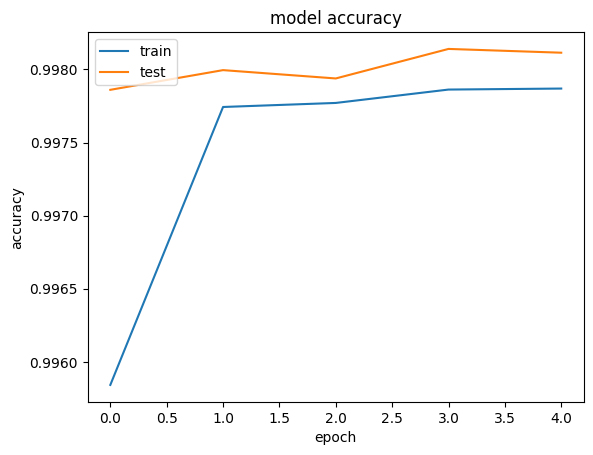

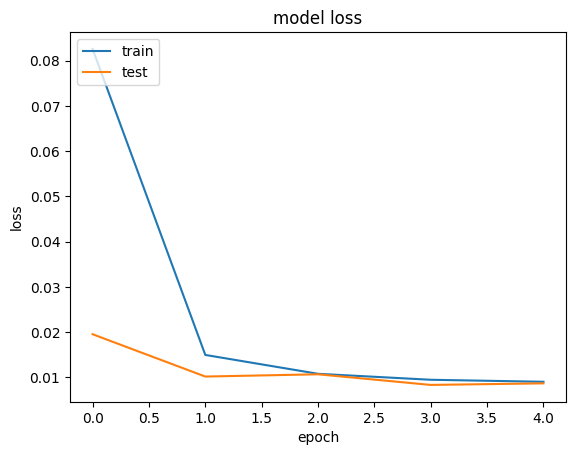

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_hat = (model.predict(X_test)>0.5).astype('int32')

6033/6033 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import seaborn as sns

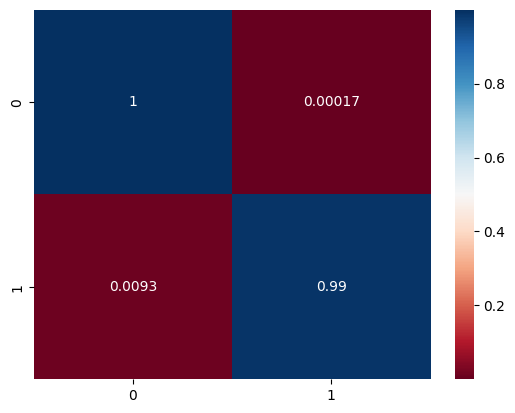

In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(matrix, annot = True, cmap = "RdBu")
plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=934aa53561a30893d5519d1dfaa5d77cd277cba5c337620c437bc5ab049c9035
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import pandas as pd

# Load your dataset (assuming it's a CSV file)
df = pd.read_csv('Friday-02-03-2018_TrafficForML_CICFlowMeter.csv')

# Extract the feature names
feature_names = list(df.columns)

# Check the extracted feature names
print(feature_names)


['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd By

In [ ]:
'''this is the lime prediction for a single time sequence for a given sample'''

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


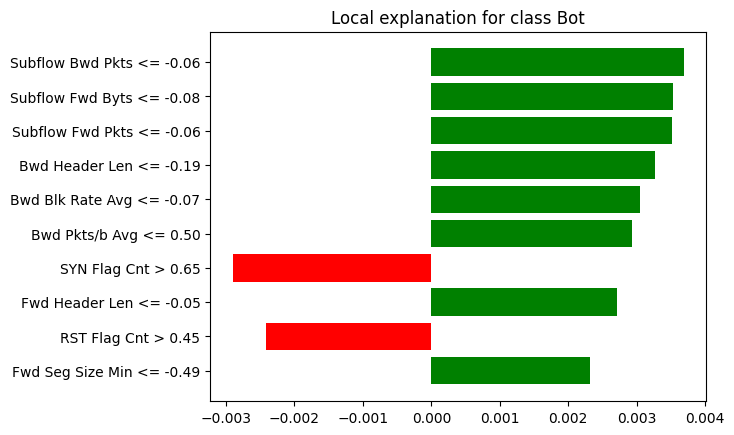

[('Subflow Bwd Pkts <= -0.06', 0.0036847677141559274), ('Subflow Fwd Byts <= -0.08', 0.003521619371448977), ('Subflow Fwd Pkts <= -0.06', 0.0035075726079526097), ('Bwd Header Len <= -0.19', 0.003262562581919395), ('Bwd Blk Rate Avg <= -0.07', 0.0030428190568358034), ('Bwd Pkts/b Avg <= 0.50', 0.0029342758986554865), ('SYN Flag Cnt > 0.65', -0.0028991463394129444), ('Fwd Header Len <= -0.05', 0.0027170540183350917), ('RST Flag Cnt > 0.45', -0.0024092878960944673), ('Fwd Seg Size Min <= -0.49', 0.0023104160199714945)]


In [ ]:
import lime
from lime import lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Flatten the input for LIME to work (since LIME works on tabular data)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create a LIME Tabular Explainer with actual feature names
explainer = lime_tabular.LimeTabularExplainer(
    X_train_flat,
    feature_names=feature_names,  # Use actual feature names
    class_names=['Benign', 'Bot'],  # Adjust these labels as per your dataset
    mode='classification'
)

def predict_fn(samples):
    n_samples = samples.shape[0]

    # Assuming time_steps = X_train.shape[2], features = X_train.shape[3], channels = 1
    time_steps = X_train.shape[2]  # Number of time steps in your model
    features = X_train.shape[3]    # Number of features in your model

    # Reshape LIME's 2D samples back to (n_samples, time_steps, features, channels)
    samples_reshaped = samples.reshape(n_samples, 1, time_steps, features)  # Adjust this based on your input shape

    return model.predict(samples_reshaped)

# Choose a random sample from the test set to explain
i = np.random.randint(0, X_test.shape[2])
sample = X_test_flat[i].reshape(1, -1)  # Flattened sample

# Explain the selected instance using LIME
exp = explainer.explain_instance(sample[0], predict_fn, num_features=10)

# Visualize the explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Save the explanation to HTML for further viewing
exp.save_to_file('/content/lime_explanation.html')

# Visualize the explanation as a plot
exp.as_pyplot_figure()
plt.show()

# You can also print out the explanation in textual form
print(exp.as_list())


In [ ]:
'''This is the lime prediction for a whole sample consisting of series of timesteps'''

import lime
import lime.lime_tabular
import numpy as np

# Wrapper function for model prediction with normalization
def predict_wrapper(input_data):
    # Reshape the input data to 3D shape (batch_size, timesteps, features)
    reshaped_data = input_data.reshape((input_data.shape[0], 1, input_data.shape[1], 1))

    # Use model to predict (logits)
    predictions = model.predict(reshaped_data)

    # Normalize the predictions so that they sum to 1 (LIME expects this)
    predictions = predictions / predictions.sum(axis=1, keepdims=True)

    return predictions

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train_flat,
    feature_names=feature_names,  # Use actual feature names
    class_names=['Benign', 'Bot'],  # Adjust these labels as per your dataset
    mode='classification'
)

# Choose a sample from the test set for explanation
i = 10  # Index of the sample you want to explain
flat_sample = X_test[i].reshape(-1)  # Flatten for LIME

# Explain the prediction using LIME, with the custom prediction function
exp = explainer.explain_instance(flat_sample,
                                 predict_wrapper,  # Use custom function
                                 num_features=10)  # Number of features to display

# Visualize the explanation
exp.show_in_notebook(show_table=True)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
true_label = y_test[i]
print(true_label)

[1. 0.]


In [ ]:
import lime
from lime import lime_tabular
import numpy as np

# Wrapper function for model prediction with normalization
def predict_wrapper(input_data):
    # Reshape the input data to 3D shape (batch_size, timesteps, features)
    reshaped_data = input_data.reshape((input_data.shape[0], 1, input_data.shape[1], 1))

    # Use model to predict (logits)
    predictions = model.predict(reshaped_data)

    # Normalize the predictions so that they sum to 1 (LIME expects this)
    predictions = predictions / predictions.sum(axis=1, keepdims=True)

    return predictions

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train_flat,
    feature_names=feature_names,  # Use actual feature names
    class_names=['Benign', 'Bot'],  # Adjust these labels as per your dataset
    mode='classification'
)

# Choose a sample from the test set for explanation
i = 1  # Index of the sample you want to explain
flat_sample = X_test[i].reshape(-1)  # Flatten for LIME

# Get the true label from the test set
true_label = np.argmax(y_test[i])  # Assuming y_test contains one-hot encoded labels

# Explain the prediction using LIME, with the custom prediction function
exp = explainer.explain_instance(flat_sample,
                                 predict_wrapper,  # Use custom function
                                 num_features=10)  # Number of features to display

# Visualize the explanation
exp.show_in_notebook(show_table=True)

# Get the model's prediction for the sample
predicted_probabilities = predict_wrapper(flat_sample.reshape(1, -1))
predicted_label = np.argmax(predicted_probabilities)  # Get the predicted class index

# Print true and predicted labels
print(f"True label: {'Benign' if true_label == 0 else 'Bot'}")
print(f"Predicted label: {'Benign' if predicted_label == 0 else 'Bot'}")

# Optionally, check if the prediction is correct
if true_label == predicted_label:
    print("The prediction is correct.")
else:
    print("The prediction is incorrect.")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
True label: Benign
Predicted label: Benign
The prediction is correct.


In [ ]:
# Save the explanation to an HTML file for further viewing
exp.save_to_file('lime_explanation.html')